In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
import crocosi.gridop as grd
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.10:38024 Dashboard: http://10.148.1.10:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [7]:
V = ['u', 'v']
dij = 1
dti = 36
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 3 GB


In [8]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 2000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
    time_counter  (time) float64 1.5e+03 1.5e+03 1.501e+03 ... 2e+03 2e+03
    f             (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
    s_rho_slice0  float32 -0.01
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    f_rho         (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
  * time          (time) float64 dask.array<chunksize=(200,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(200, 722, 257), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(200, 721, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [9]:
from collections import OrderedDict
def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [11]:
vtst = x2rho(ds['v'].isel(time=500),r.xgrid,'extrapolate').compute()
utst = x2rho(ds['u'].isel(time=500),r.xgrid,'extrapolate').compute()

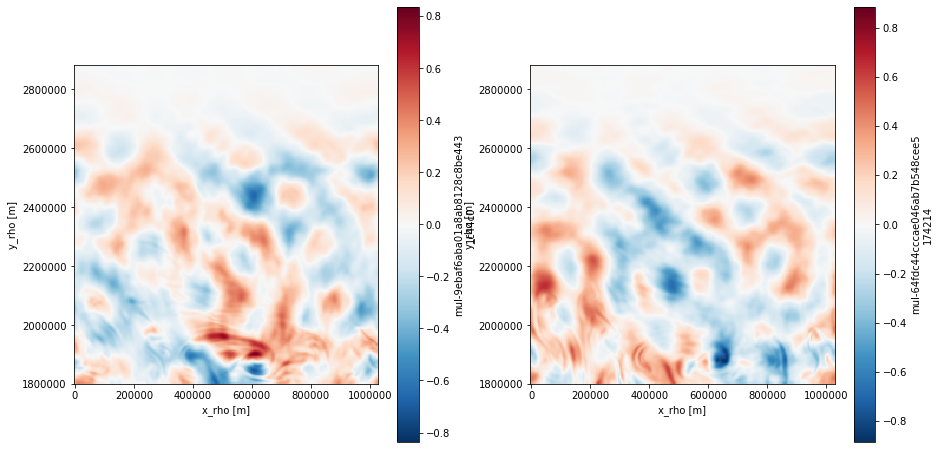

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
vtst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[1]);ax[1].set_aspect('equal')
utst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[0]);ax[0].set_aspect('equal')

In [29]:
vtsti = vtst.sel(y_rho=slice(1800*1e3,None))
utsti = utst.sel(y_rho=slice(1800*1e3,None))
Utsti = 0.5*np.sqrt(vtsti**2+utsti**2)

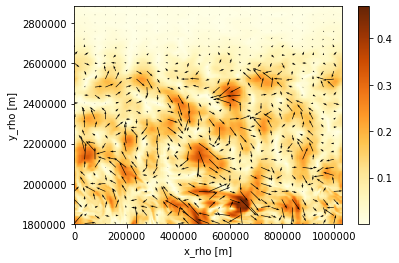

In [47]:
Utsti.plot(cmap='YlOrBr')
plt.quiver(utsti.x_rho[::10],utsti.y_rho[::10],utsti[::10,::10],vtsti[::10,::10])

In [53]:
ds

<xarray.Dataset>
Dimensions:       (time: 2000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    f             (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
  * time          (time) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.501e+03 ... 2e+03 2e+03
    f_rho         (y_rho) float32 7.96396e-05 7.97044e-05 ... 0.00012636039
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(200, 722, 257), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(200, 721, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [10]:
v = ds['v'].compute()
u = ds['u'].compute()

In [155]:
def gen_figs(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names in zip([ui,vi,U],ax,['RdBu_r','RdBu_r','YlOrBr'],['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$']):
        V.plot(ax=axs,cmap=cmap,cbar_kwargs={'label':names})
        axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(m)');axs.set_xlabel(r'$x_\rho$(m)')
    ax[2].quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=2))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/North_uv/'+name,overwrite=True)
        plt.close()

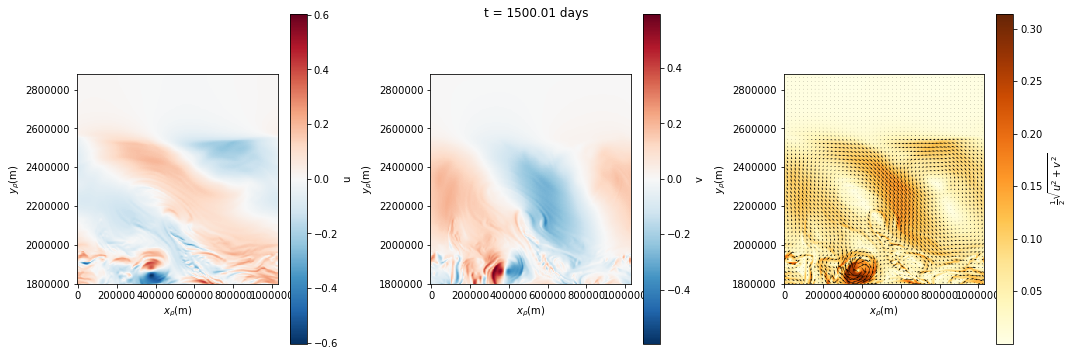

In [159]:
gen_figs(0,1800,2880,5,(15,5),savefig=False,name='test.png')

In [161]:
for t in range(v.sel(time=slice(1500,1700)).time.size):
    n='t%s'%t
    gen_figs(t,1800,2880,5,(15,5),savefig=True,name=n+'.png')

In [17]:
def gen_fig(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    fig,ax = plt.subplots(figsize=figsize)
    U.plot(ax=ax,cmap='YlOrBr',vmin=0,vmax=0.5,cbar_kwargs={'label':r'$\frac{1}{2}\sqrt{u^2+v^2}$'})
    ax.set_aspect('equal');ax.set_ylabel(r'$y_\rho$(m)');ax.set_xlabel(r'$x_\rho$(m)')
    ax.quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    plt.title('t = %s days'%np.around(v.isel(time=t).time.values,decimals=2))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/North_uv/'+name,overwrite=True)
        plt.close()

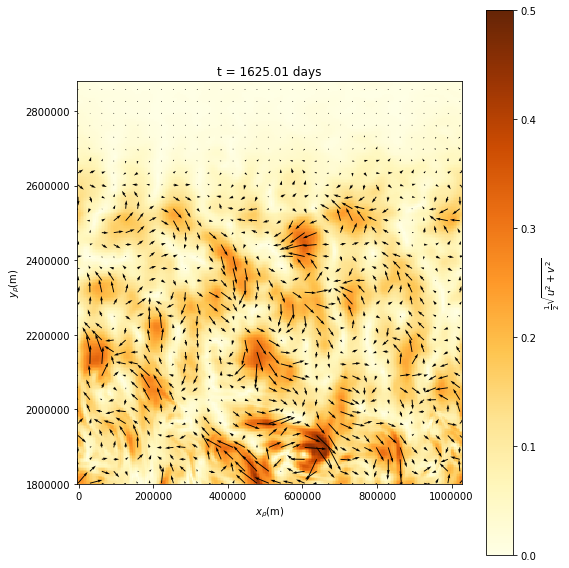

In [48]:
gen_fig(500,1800,2880,8,(8,8))

In [49]:
for t in range(v.sel(time=slice(1500,1700)).time.size):
    n='t%s'%t
    gen_fig(t,1800,2880,8,(7,7),savefig=True,name=n+'.png')

In [ ]:
import matplotlib.animation as animation

fig = plt.figure() # initialise la figure
im = v.isel(time=0).sel(y_v=slice(1800*1e3,None)).plot(animated=True)
#plt.xlim(xmin, xmax)
#plt.ylim(-1,1)
i=0
def updatefig(*args):
   # global i
    for i in range(v.sel(time=slice(1500,1700)).time.size):
        im.set_array(v.isel(time=i).sel(y_v=slice(1800*1e3,None)).values)
    return im,
    #plt.pause(0.01)
ani = animation.FuncAnimation(fig, updatefig,  blit=True)

# fonction à définir quand blit=True
# crée l'arrière de l'animation qui sera présent sur chaque image
def init():
    line.set_data([],[])
    return line,

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
plt.show()
#ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=False)

In [50]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
